# 1. Setting up the environment

## 1.1 Load Packages

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from statsmodels.tsa.stattools import ccf
import statsmodels.formula.api as smf
from scipy import stats
import scipy.stats as stats
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from datetime import date
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

## 1.2 Load Data

In [2]:
train_data_raw = pd.read_csv("/Users/wgc/Desktop/qbus3600GroupAsm/FinSalesPriceData_train.csv")
test_data_raw = pd.read_csv("/Users/wgc/Desktop/qbus3600GroupAsm/FinSalesPriceData_test.csv")
competitor_data_raw = pd.read_csv("/Users/wgc/Desktop/qbus3600GroupAsm/CompetitorPriceData.csv")

In [3]:
train_data_raw.head()

,calendar_day,article_id,article_desc,category,subcategory,segment,brand,brandtype,sell_price,promo_price,promo_sales,promo_units,gross_profit,scanback,sales_amount,sales_units,cnt_site_art_ranged,cnt_site_art_ranged_pstv_soh,tot_soh_ranged_sites,gst_flag
0,2022-02-07,196544,Skin Control Pimple Patch Micro Dart 9pk,Skin & Sun Care,Skincare Face,Other,SKIN CONTROL,National Brand,13.00,13.0,13.0,1,86.550,0.0,190.7080,15,176,171,1444.0,Y
1,2022-02-07,103515,Spascriptions Superfoods Masks 3x 50ml,Skin & Sun Care,Skincare Face,Masks,SPASCRIPTIONS,National Brand,20.00,NaN,NaN,0,28.719,0.0,59.7999,3,176,175,1907.0,Y
2,2022-02-07,103517,Spascriptions Retinol Facial Serum,Skin & Sun Care,Skincare Face,Masks,SPASCRIPTIONS,National Brand,18.00,NaN,NaN,0,17.158,0.0,35.8198,2,176,174,844.0,Y
3,2022-02-07,103518,Spascriptions Collagen Facial Serum,Skin & Sun Care,Skincare Face,Masks,SPASCRIPTIONS,National Brand,18.00,NaN,NaN,0,42.926,0.0,89.6396,5,176,174,938.0,Y
4,2022-02-07,103520,7th Heaven Blackhead Stardust Face Mask,Skin & Sun Care,Skincare Face,7Th Heaven,7TH HEAVEN,National Brand,6.95,NaN,NaN,0,16.919,0.0,41.5209,6,176,173,1960.0,Y


## 1.3 Make a copy of the data

In [4]:
# make a copy of the data
data_train = train_data_raw.copy()
data_test = test_data_raw.copy()
data_c = competitor_data_raw.copy()

# 2. Data Preprocessing

## 2.1 Split the train data for train and validation sets

In [5]:
data_train_idx, data_val_idx = train_test_split(data_train.index, test_size=0.2, random_state=3600)
data_train = train_data_raw.loc[data_train_idx]
data_val = train_data_raw.loc[data_val_idx]

print(data_train.shape)
print(data_val.shape)
print(data_test.shape)


(1000013, 20)
(250004, 20)
(605777, 20)


## 2.2 Missing Value Management

In [6]:
# function that process the selling price data
def missing_sell_price(data):
    # Calculate NA sell price using sales amount / sales units
    data['sell_price'] = data['sell_price'].fillna(data['sales_amount']/data['sales_units'])
    # Use previous sell price of no sales amount
    data['sell_price'] = data['sell_price'].fillna(method='ffill')
    return data

# function that process missing promo price and promo sales
def missing_promo(data):
    for idx in data.index:
        if pd.isna(data['promo_price'][idx]) and pd.notna(data['promo_sales'][idx]):
            data['promo_sales'][idx] = np.nan
    return data

In [7]:
data_train = missing_sell_price(data_train)
data_train = missing_promo(data_train)

data_val = missing_sell_price(data_val)
data_val = missing_promo(data_val)

data_test = missing_sell_price(data_test)
data_test = missing_promo(data_test)

In [8]:
print(data_train.shape)
print(data_val.shape)
print(data_test.shape)

(1000013, 20)
(250004, 20)
(605777, 20)


## 2.3 Inconsistencies and Anomalies

### 2.3.1 Negative Sell Price, Promotion Price, Promotional Sales, and Scanback

In [9]:
# function that drop negative promotion negative, negative sell price
def drop_neg_invalid_rows(data):
    data = data.drop(data[data['promo_price'] < 0].index)
    data = data.drop(data[data['promo_sales'] < 0].index)
    data = data.drop(data[data['scanback'] < 0].index)
    data = data.drop(data[data['sell_price'] < 0].index)
    return data

data_train = drop_neg_invalid_rows(data_train)
data_val = drop_neg_invalid_rows(data_val)
data_test = drop_neg_invalid_rows(data_test)

print(data_train.shape)
print(data_val.shape)
print(data_test.shape)

(997831, 20)
(249465, 20)
(604344, 20)


### 2.3.2 Availability Issues

In [10]:
# function that drop rows with availability issues
def rm_availability_issue(data):
    condition = data[(data['cnt_site_art_ranged'] > 0) & (data['tot_soh_ranged_sites'] == 0)]
    data = data.drop(condition.index)
    return data

data_train = rm_availability_issue(data_train)
data_val = rm_availability_issue(data_val)
data_test = rm_availability_issue(data_test)

print(data_train.shape)
print(data_val.shape)
print(data_test.shape)

(972425, 20)
(243254, 20)
(596838, 20)


### 2.3.3 Invalid Sales (Sales Units and Promotional Units)

In [11]:
# function that drop rows where promo units or sales units are more than stock
def drop_sell_more_than_stock(data):
    data = data.drop(data[data['sales_units'] > data['tot_soh_ranged_sites']].index)
    data = data.drop(data[data['promo_units'] > data['tot_soh_ranged_sites']].index)
    return data

data_train = drop_sell_more_than_stock(data_train)
data_val = drop_sell_more_than_stock(data_val)
data_test = drop_sell_more_than_stock(data_test)

print(data_train.shape)
print(data_val.shape)
print(data_test.shape)

(919962, 20)
(230080, 20)
(562224, 20)


### 2.3.4 Duplicates

In [12]:
# function that remove duplicates
def remove_duplicates(data):
    duplicate = data.duplicated()
    data = data.drop(data[duplicate].index)
    return data

data_train = remove_duplicates(data_train)
data_val = remove_duplicates(data_val)
data_test = remove_duplicates(data_test)

print(data_train.shape)
print(data_val.shape)
print(data_test.shape)

(919962, 20)
(230080, 20)
(562224, 20)


### 2.3.5 Promo Price higher and equal to Sell Price

In [13]:
def remove_invalid_promo(data):
    data = data.drop(data[(data['promo_price'] >= data['sell_price'])].index)
    return data

data_train = remove_invalid_promo(data_train)
data_val = remove_invalid_promo(data_val)
data_test = remove_invalid_promo(data_test)

print(data_train.shape)
print(data_val.shape)
print(data_test.shape)

(919146, 20)
(229874, 20)
(561534, 20)


### 2.3.5 Drop Inventory Features
- This is because we won't know for certain what the inventory levels will be in the future.

In [14]:
data_train = data_train.drop(['cnt_site_art_ranged', 'cnt_site_art_ranged_pstv_soh', 'tot_soh_ranged_sites'], axis=1)
data_val = data_val.drop(['cnt_site_art_ranged', 'cnt_site_art_ranged_pstv_soh', 'tot_soh_ranged_sites'], axis=1)
data_test = data_test.drop(['cnt_site_art_ranged', 'cnt_site_art_ranged_pstv_soh', 'tot_soh_ranged_sites'], axis=1)

## 2.4 Data Types Transformation
1. Convert `calendar_day` to datetime
2. Create dummy variables for categorical features
    - `article_desc` does not have a clear categorisation, so we will not create dummy for it

In [15]:
def cat_to_dum(data, var_name):
    category_dummies = pd.get_dummies(data[var_name], prefix=var_name)
    data = pd.concat([data, category_dummies], axis=1)
    data = data.drop(var_name, axis=1)
    return data
    
def data_type_transform(data):
    # find the categorical columns
    cat_columns = data.select_dtypes(include=['object']).columns
    
    # transform calendar_day to datetime object
    data['calendar_day'] = pd.to_datetime(data['calendar_day'])
    
    # transform category to dummy
    data = cat_to_dum(data, 'category')
    
    # transform sub_category to dummy
    data = cat_to_dum(data, 'subcategory')
    
    # transform segment to dummy
    data = cat_to_dum(data, 'segment')
    
    # transform brand to dummy
    data = cat_to_dum(data, 'brand')
    
    # transform brandtype to dummy
    data = cat_to_dum(data, 'brandtype')
    
    # transform gst to dummy
    data = cat_to_dum(data, 'gst_flag')

    return data

In [16]:
data_train_with_dummy = data_train.copy()
data_train_with_dummy = data_type_transform(data_train_with_dummy)

data_val_with_dummy = data_val.copy()
data_test_with_dummy = data_test.copy()

data_val_with_dummy = data_type_transform(data_val_with_dummy)
data_test_with_dummy = data_type_transform(data_test_with_dummy)

In [17]:
print(data_train_with_dummy.shape)
print(data_val_with_dummy.shape)
print(data_test_with_dummy.shape)

(919146, 413)
(229874, 413)
(561534, 413)


## 2.5 Additional Variables
1. Revised profits:
    `net_proft` = `gross_profit` + `scanback`

2. Cost of purchasing:
    2.1 if GST is present: `sales_amount_exclude_gst` = `sales_amount` / 1.1
    2.2 if GST is absent: `sales_amount_exclude_gst` = `sales_amount`
    `cost_of_purchasing` = `sales_amount_exclude_gst` - `net_profit`

3. Sales units per dollar decrease to see the price elasticity of the article:
    `sales_units_per_dollar` = `promo_units` / (`selling_price` - `promo_price`)

4. Day of Week
    `day_of_week` = `date`.dt.dayofweek

5. Whether competitor has a lower selling or shelves price

6. Whether the article is on promotion (0 for no, 1 for yes)


In [18]:
def new_var(data):
    # Calculate revised net profit
    data['net_profit'] = data['gross_profit'] + data['scanback']
    
    # Calculate sales amount excluding GST using vectorized operation
    data['sales_amount_exclude_gst'] = data['sales_amount'] / (1.1 if 'gst_flag_Y' in data.columns and data['gst_flag_Y'].all() else 1)
    
    # Calculate cost of purchasing
    data['cost_of_purchasing'] = data['sales_amount_exclude_gst'] - data['net_profit']
    
    # Calculate sales units per dollar decrease due to promotions
    data['marginal_sales_per_dollar_decrease'] = data['promo_units'] / (data['sell_price'] - data['promo_price'])
    
    # Extract day of week from 'calendar_day'
    data['day_of_week'] = data['calendar_day'].dt.dayofweek
    ## treat day_of_week as categorical
    data = cat_to_dum(data, 'day_of_week')
    
    # Identify whether the article is on promotion
    data['on_promo'] = data['promo_price'].apply(lambda x: 1 if x > 0 else 0)
    ## change on_promo to bool
    data['on_promo'] = data['on_promo'].astype(bool)
    
    return data

data_train_with_dummy = new_var(data_train_with_dummy)
data_val_with_dummy = new_var(data_val_with_dummy)
data_test_with_dummy = new_var(data_test_with_dummy)

In [19]:
print(data_train_with_dummy.shape)
print(data_val_with_dummy.shape)
print(data_test_with_dummy.shape)

(919146, 425)
(229874, 425)
(561534, 425)


## 2.6 Standardisation

### 2.6.1 Split into normal and promotional data

In [20]:
def normal_promo_sets(data):
    return data[data["promo_price"].isna()], data[data["promo_price"].notna()]

# Split data into Normal Sales and Promo Sales
train_normal, train_promo = normal_promo_sets(data_train_with_dummy)
test_normal, test_promo = normal_promo_sets(data_test_with_dummy)
val_normal, val_promo = normal_promo_sets(data_val_with_dummy)

# check shape
print(train_normal.shape)
print(train_promo.shape)
print(test_normal.shape)
print(test_promo.shape)
print(val_normal.shape)
print(val_promo.shape)

(733589, 425)
(185557, 425)
(441888, 425)
(119646, 425)
(183182, 425)
(46692, 425)


# DESTANDARDISE

### 2.6.2 Standardise the data

In [21]:
# # check numerical columns
# train_normal.select_dtypes(include=['int', 'float']).columns

# # colns that have na values for normal sales
# print(train_normal.columns[train_normal.isna().any()])

# # colns that have na values for promo sales
# print(train_promo.columns[train_promo.isna().any()])
# print(train_promo.columns[train_promo.isin([np.nan, np.inf, -np.inf]).any()])
# print(train_promo['marginal_sales_per_dollar_decrease'].value_counts())

In [22]:
# def prepare_for_std(data, promo=False):
#     # rm the columns that are misclassified as numerical
#     data['article_id'] = data_train_with_dummy['article_id'].astype(str)
    
#     # consider two cases: normal sales and promo sales
#     ## for normal sales drop promo columns
#     if promo == False:
#         data = data.drop(['promo_price', 'promo_sales', 'marginal_sales_per_dollar_decrease'], axis=1)
#     return data

# train_normal = prepare_for_std(train_normal)
# train_promo = prepare_for_std(train_promo, promo=True)
# val_normal = prepare_for_std(val_normal)
# val_promo = prepare_for_std(val_promo, promo=True)
# test_normal = prepare_for_std(test_normal)
# test_promo = prepare_for_std(test_promo, promo=True)

# # check shape
# print(train_normal.shape)
# print(train_promo.shape)
# print(val_normal.shape)
# print(val_promo.shape)
# print(test_normal.shape)
# print(test_promo.shape)

In [23]:
# # standardise all numerical columns
# def standardise(data):    
#     # standardise all numerical columns
#     scaler = StandardScaler()
#     data[data.select_dtypes(include=['int', 'float']).columns] = scaler.fit_transform(data.select_dtypes(include=['int', 'float']))
#     return data

# train_normal = standardise(train_normal)
# train_promo = standardise(train_promo)
# val_normal = standardise(val_normal)
# val_promo = standardise(val_promo)
# test_normal = standardise(test_normal)
# test_promo = standardise(test_promo)

# # check shape
# print(train_normal.shape)
# print(train_promo.shape)
# print(val_normal.shape)
# print(val_promo.shape)
# print(test_normal.shape)
# print(test_promo.shape)

## 2.7 Split data into x features and y target

In [24]:
def y_x_split(data):
    return data["sales_units"], data.drop("sales_units", axis =1)

# Split data into x and y sets
y_train_normal, x_train_normal = y_x_split(train_normal)
y_train_promo, x_train_promo = y_x_split(train_promo)

y_test_normal, x_test_normal = y_x_split(test_normal)
y_test_promo, x_test_promo = y_x_split(test_promo)

y_val_normal, x_val_normal = y_x_split(val_normal)
y_val_promo, x_val_promo = y_x_split(val_promo)

# check shape
print(y_train_normal.shape)
print(x_train_normal.shape)
print(y_train_promo.shape)
print(x_train_promo.shape)

print(y_test_normal.shape)
print(x_test_normal.shape)
print(y_test_promo.shape)
print(x_test_promo.shape)

print(y_val_normal.shape)
print(x_val_normal.shape)
print(y_val_promo.shape)
print(x_val_promo.shape)

(733589,)
(733589, 424)
(185557,)
(185557, 424)
(441888,)
(441888, 424)
(119646,)
(119646, 424)
(183182,)
(183182, 424)
(46692,)
(46692, 424)


In [25]:
print(y_val_normal)

799286     7
874000     6
913328    12
691429    56
489002     8
          ..
908629     2
834373     0
72894      6
851845     4
906202    21
Name: sales_units, Length: 183182, dtype: int64


## 2.8 Merge x_normal and y_normal, x_promo and y_promo

In [26]:
train_normal = pd.concat([x_train_normal, y_train_normal], axis=1)
val_normal = pd.concat([x_val_normal, y_val_normal], axis=1)
test_normal = pd.concat([x_test_normal, y_test_normal], axis=1)

In [27]:
train_promo = pd.concat([x_train_promo, y_train_promo], axis=1)
val_promo = pd.concat([x_val_promo, y_val_promo], axis=1)
test_promo = pd.concat([x_test_promo, y_test_promo], axis=1)

In [28]:
#train_normal.head

## 2.9 Explore significant variables 
### Normal Sales:

In [29]:
correlations = train_normal.corrwith(train_normal['sales_units']).abs()
significant_features = correlations[correlations > 0.1]  
print(significant_features.sort_values(ascending=False))

sales_units                    1.000000
sales_amount                   0.836164
sales_amount_exclude_gst       0.836164
cost_of_purchasing             0.824560
net_profit                     0.754956
gross_profit                   0.754825
brand_QUILTON                  0.474344
segment_Quilton                0.474344
subcategory_Toilet Tissue      0.465372
segment_Own Brand Wipes        0.294142
brand_DYMPLES                  0.278070
segment_Paper Towels           0.267068
subcategory_Paper Towels       0.267068
brand_VIVA                     0.267068
brand_KLEENEX                  0.221496
brandtype_Private Label        0.210999
category_Skin & Sun Care       0.194875
brand_STRIKE                   0.181437
segment_Cottonelle             0.179180
category_Household Cleaning    0.178769
article_id                     0.163817
subcategory_Baby Wipes         0.160726
subcategory_Skincare Face      0.156036
brandtype_National Brand       0.114093
dtype: float64


In [30]:
print(significant_features.shape)

(24,)


### Promo Sales:

In [31]:
correlations = train_promo.corrwith(train_promo['sales_units']).abs()
significant_features = correlations[correlations > 0.1]  
print(significant_features.sort_values(ascending=False))

sales_units                           1.000000
promo_units                           0.947334
sales_amount                          0.689079
sales_amount_exclude_gst              0.689079
cost_of_purchasing                    0.670593
promo_sales                           0.642259
marginal_sales_per_dollar_decrease    0.555676
scanback                              0.552674
net_profit                            0.419600
brand_DYMPLES                         0.352412
segment_Own Brand Wipes               0.352412
brandtype_Private Label               0.341572
category_Skin & Sun Care              0.317143
subcategory_Skincare Face             0.282413
category_Household Cleaning           0.230199
subcategory_Baby Wipes                0.198109
subcategory_Prewash & Conditio        0.182965
gross_profit                          0.182345
brand_HUGGIES                         0.181430
article_id                            0.180326
subcategory_Paper Towels              0.174463
brand_VIVA   

In [32]:
print(significant_features.shape)

(39,)


# Regression

## Varaibles for Regression
### Normal Sales:

In [33]:
# all binary columns:
binary_columns = []
for column in train_normal.columns:
    if set(train_normal[column].dropna().unique()) == {0, 1}:
        binary_columns.append(column)
        
train_normal_binary = train_normal[binary_columns]

#print(train_normal_binary.head())

In [34]:
# significant binary columns:
columns_to_keep = [
    'brand_QUILTON',
    'segment_Quilton',
    'subcategory_Toilet Tissue',
    'segment_Own Brand Wipes',
    'brand_DYMPLES',
    'segment_Paper Towels',
    'subcategory_Paper Towels',
    'brand_VIVA',
    'brand_KLEENEX',
    'brandtype_Private Label',
    'category_Skin & Sun Care',
    'brand_STRIKE',
    'segment_Cottonelle',
    'category_Household Cleaning',
    'subcategory_Baby Wipes',
    'subcategory_Skincare Face',
    'brandtype_National Brand'
]

binary_columns_to_keep = []

for column in columns_to_keep:
    if column in train_normal.columns and set(train_normal[column].dropna().unique()) == {0, 1}:
        binary_columns_to_keep.append(column)

train_normal_filtered_binary = train_normal[binary_columns_to_keep]
#print(train_normal_filtered_binary.head())

In [35]:
# Merge
train_normal_remaining = train_normal.drop(columns=train_normal_binary.columns, errors='ignore')
train_combined = pd.concat([train_normal_remaining, train_normal_filtered_binary], axis=1)
#print(train_combined.head())

In [36]:
train_normal = train_combined
print(train_normal.shape)

(733589, 33)


### Promo Sales:

In [37]:
# all binary columns:
binary_columns = []
for column in train_promo.columns:
    if set(train_promo[column].dropna().unique()) == {0, 1}:
        binary_columns.append(column)
        
train_promo_binary = train_promo[binary_columns]
#print(train_promo_binary.head())

In [38]:
# significant binary columns:
columns_to_keep = [
    'segment_Own Brand Wipes',
'brand_DYMPLES',
'brandtype_Private Label',
'category_Skin & Sun Care',
'subcategory_Skincare Face',
'category_Household Cleaning',
'subcategory_Baby Wipes',
'subcategory_Prewash & Conditio',
'gross_profit',
'brand_HUGGIES',
'subcategory_Paper Towels',
'brand_VIVA',
'segment_Paper Towels',
'segment_Fabric Conditioner',
'subcategory_Laundry Detergent',
'segment_Huggies Jumbo Nappy',
'sell_price',
'subcategory_Deodorants',
'subcategory_Disposable Nappies',
'brand_DUO',
'brand_REXONA',
'category_Baby Consumables',
'brand_FLUFFY',
'subcategory_Cleaning Products',
'segment_Olay',
'brand_OLAY',
'segment_Bathroom',
'promo_price'

]

binary_columns_to_keep = []

for column in columns_to_keep:
    if column in train_promo.columns and set(train_promo[column].dropna().unique()) == {0, 1}:
        binary_columns_to_keep.append(column)

train_promo_filtered_binary = train_promo[binary_columns_to_keep]
#print(train_promo_filtered_binary.head())

In [39]:
# Merge
train_promo_remaining = train_promo.drop(columns=train_promo_binary.columns, errors='ignore')
train_combined = pd.concat([train_promo_remaining, train_promo_filtered_binary], axis=1)
#print(train_combined.head())

In [40]:
train_promo = train_combined
print(train_promo.shape)

(185557, 111)


# Regression Model
## Noml Sales 
### Fetures Seletion
#### Correlation Metrix

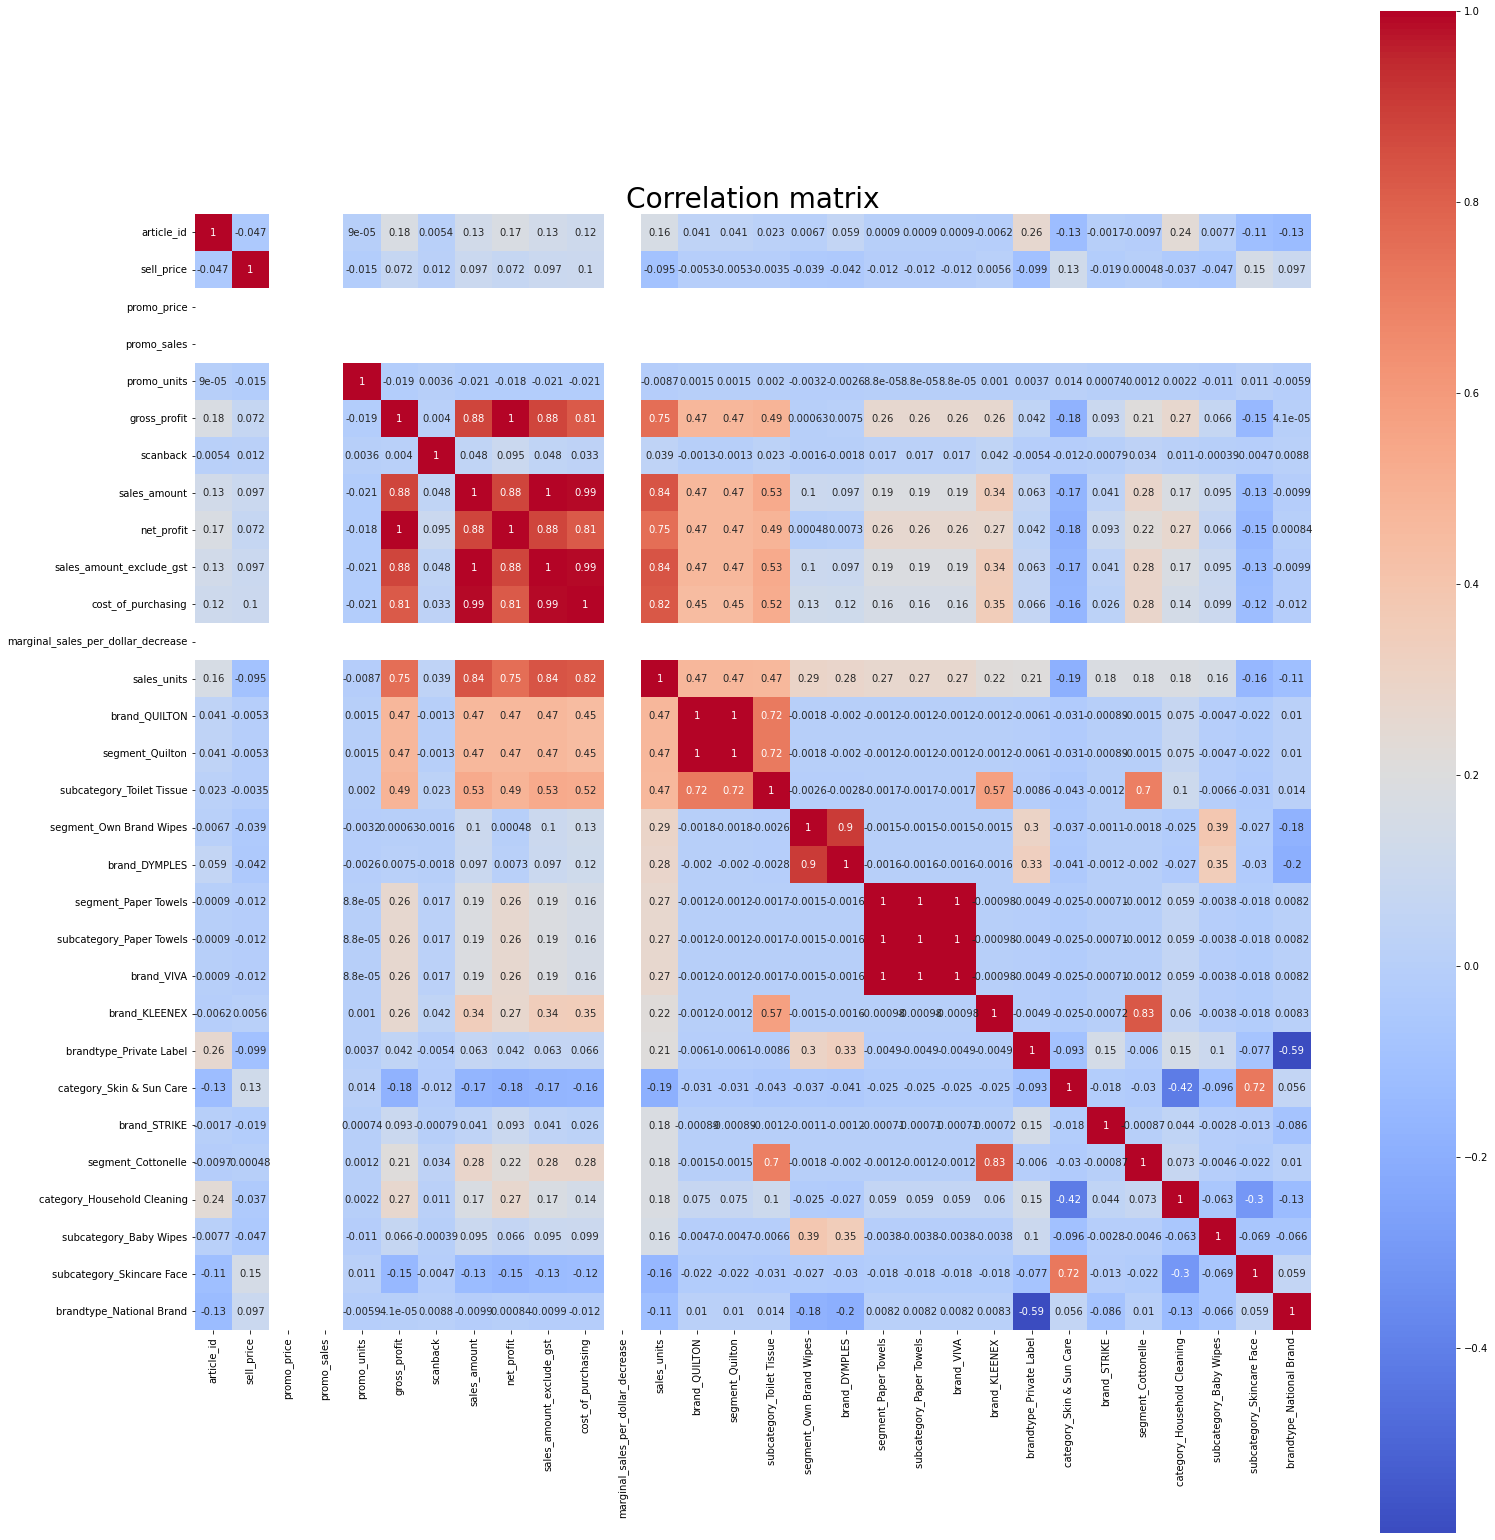

In [41]:
# drop 'on_promo' columns
train_normal = train_normal.drop(columns=['on_promo'], errors='ignore')

#Metrix
df = train_normal
plt.subplots(figsize=(25, 28))

sns.heatmap(df.corr(), square=True, annot=True, cmap="coolwarm")
plt.title('Correlation matrix', fontsize=28)
plt.show()

#### SLR

In [42]:
x = 'sales_amount'
y = 'sales_units'

x_train = train_normal[x]
y_train = train_normal[y]
x_val = val_normal[x]
y_val = val_normal[y]
x_test = test_normal[x]
y_test = test_normal[y]

In [43]:
# train data
SLR = smf.ols(formula=f"{y} ~ {x}", data=train_normal).fit()
#SLR.summary()

# validation data
y_val_pred = SLR.predict(x_val)
SLR_val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
print("SLR Validation RMSE:", SLR_val_rmse)

# test data

y_test_pred = SLR.predict(x_test)
SLR_test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
print("SLR Test RMSE:", SLR_test_rmse)

SLR Validation RMSE: 31.683274357831767
SLR Test RMSE: 30.79818201615635


In [44]:
print(x_train)

161977      109.3029
901618      104.7192
368078        0.0000
62227       215.1347
358737        0.0000
             ...    
240350        0.0000
1155127    4678.0921
582945      426.7345
185107      152.9044
330030       27.6703
Name: sales_amount, Length: 733589, dtype: float64


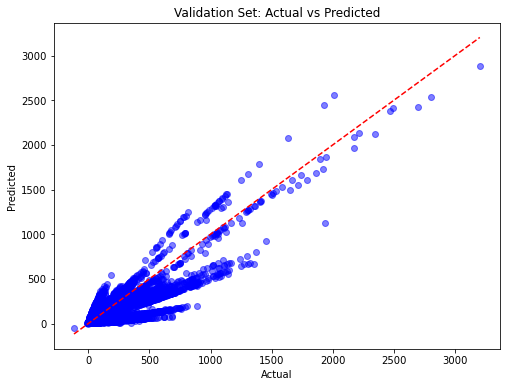

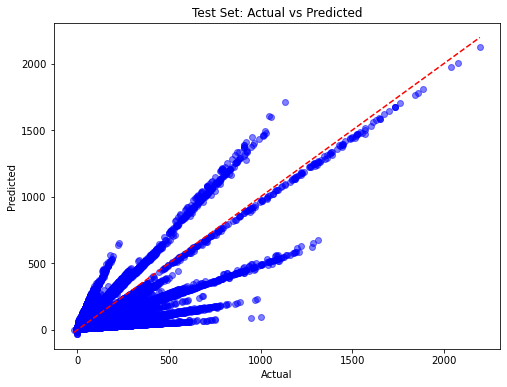

In [45]:
import matplotlib.pyplot as plt

#validation set
plt.figure(figsize=(8, 6))
plt.scatter(y_val, y_val_pred, color='blue', alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], color='red', linestyle='--')
plt.title('Validation Set: Actual vs Predicted')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

# test set
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.title('Test Set: Actual vs Predicted')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()


#### MLR

In [46]:
correlation = train_normal.corr()
#variable selected
x = correlation[correlation['sales_units'] > 0.4].index.tolist()
x.remove('sales_units')
y = 'sales_units'

x_train = train_normal[x]
y_train = train_normal[y]
x_val = val_normal[x]
y_val = val_normal[y]
x_test = test_normal[x]
y_test = test_normal[y]

In [47]:
# min RMSE and optimal solution
min_rmse = float('inf')
optimal_x = x.copy()

# Backward
for i in range(len(x)):
    
    temp_x = x.copy()
    del temp_x[i]
    
    # train model & RMSE
    model = LinearRegression()
    model.fit(x_train[temp_x], y_train)
    y_val_pred = model.predict(x_val[temp_x])
    rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    
    # update RMSE and x
    if rmse < min_rmse:
        min_rmse = rmse
        optimal_x = temp_x

# evaluate in validation set
model = LinearRegression()
model.fit(x_train[optimal_x], y_train)
y_val_pred = model.predict(x_val[optimal_x])
MLR_val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))

# optimal_x and validation RMSE
print("Optimal features:", optimal_x)
print("MLR Validation RMSE:", MLR_val_rmse)

# test data RMSE
y_test_pred = model.predict(x_test[optimal_x])
MLR_test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
print("MLR Test RMSE:", MLR_test_rmse)

Optimal features: ['sales_amount', 'net_profit', 'sales_amount_exclude_gst', 'cost_of_purchasing', 'brand_QUILTON', 'segment_Quilton', 'subcategory_Toilet Tissue']
MLR Validation RMSE: 31.131211306865346
MLR Test RMSE: 30.46752658707113


#### LASSO

In [48]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error
import numpy as np


# Scale features
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_val_scaled = scaler.transform(x_val)
x_test_scaled = scaler.transform(x_test)

# LASSO Model for Feature Selection
lasso = LassoCV(cv=5, random_state=3600)
lasso.fit(x_train_scaled, y_train)

# Output the optimal alpha chosen by LassoCV
print("Selected alpha:", lasso.alpha_)

# Select non-zero coefficient features
selected_features = [feature for i, feature in enumerate(optimal_x) if lasso.coef_[i] != 0]
print("Selected features:", selected_features)

# Prediction and evaluation on validation data
y_val_pred = lasso.predict(x_val_scaled)
lasso_val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
print("LASSO Validation RMSE:", lasso_val_rmse)

# Prediction and evaluation on test data
y_test_pred = lasso.predict(x_test_scaled)
lasso_test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
print("LASSO Test RMSE:", lasso_test_rmse)


Selected alpha: 0.049146852808058666
Selected features: ['sales_amount', 'net_profit', 'sales_amount_exclude_gst', 'cost_of_purchasing', 'segment_Quilton', 'subcategory_Toilet Tissue']
LASSO Validation RMSE: 31.13308704114495
LASSO Test RMSE: 30.464683827180092


#### Polynomial 


In [ ]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

# Define a function to calculate RMSE 
def rmse_cv(model, X, y):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=5))
    return rmse

# Initialize lists to store results
best_rmse = float('inf')
best_features = None

# Define the range of polynomial degrees to search
degrees = [1, 2, 3, 4, 5]

# Loop through each degree
for degree in degrees:
    pipeline = Pipeline([
        ('feature_selection', SelectKBest(score_func=f_regression)),
        ('polynomial_features', PolynomialFeatures(degree=degree)),
        ('regression', LinearRegression())
    ])

    #feature selection
    param_grid = {
        'feature_selection__k': np.arange(1, len(x_train.columns)+1),
    }

    #grid search
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(x_train, y_train)

    # best model
    best_model = grid_search.best_estimator_

    # RMSE of the best model on validation set
    val_rmse = rmse_cv(best_model, x_val, y_val).mean()

    # If this model has the lowest RMSE, update best_rmse and best_features
    if val_rmse < best_rmse:
        best_rmse = val_rmse
        best_features = best_model.named_steps['feature_selection'].get_support()

# Get the selected features
Polynomial_selected_features = x_train.columns[best_features]

# train the best model on the full training set
best_model.fit(x_train, y_train)

# Calculate RMSE on validation set
Polynomial_val_rmse = np.sqrt(mean_squared_error(y_val, best_model.predict(x_val)))

# Calculate RMSE on test set
Polynomial_test_rmse = np.sqrt(mean_squared_error(y_test, best_model.predict(x_test)))

print(" Polynomial Best Validation RMSE:", Polynomial_val_rmse)
print("Polynomial Test RMSE:", Polynomial_test_rmse)
print("Polynomial Selected Features:", Polynomial_selected_features)


#### Log transformation

In [ ]:
# check NaN and infinite values
print("NaN in Training:", x_train.isnull().sum().sum())
print("NaN in Validation:", x_val.isnull().sum().sum())
print("NaN in Testing:", x_test.isnull().sum().sum())

print("Inf in Training:", np.isinf(x_train).values.sum())
print("Inf in Validation:", np.isinf(x_val).values.sum())
print("Inf in Testing:", np.isinf(x_test).values.sum())

# Negative or zero value
if 'sales_amount' in x_train.columns:
    print("Zero or negative values in sales_amount:", (x_train['sales_amount'] <= 0).sum())

    x_train['sales_amount'] = np.log(x_train['sales_amount'] + 1)
    x_val['sales_amount'] = np.log(x_val['sales_amount'] + 1)
    x_test['sales_amount'] = np.log(x_test['sales_amount'] + 1)

print(x_train.describe())

x_train = x_train.astype('float64')
x_val = x_val.astype('float64')
x_test = x_test.astype('float64')


sales_amount has 571677 Zero or negative values

#### Ridge
In ridge regression, because it can handle certain multicollinearity, more variables can be considered for modeling to see the overall performance of the model.

In [ ]:
import pandas as pd
import numpy as np


x_val = pd.DataFrame(x_val)


print("NaN values before:", x_val.isna().sum().sum())
print("Infinite values before:", np.isinf(x_val).sum().sum())


x_val.fillna(x_val.mean(), inplace=True)


x_val.replace([np.inf, -np.inf], np.nan, inplace=True)
x_val.fillna(x_val.mean(), inplace=True)

print("NaN values after:", x_val.isna().sum().sum())
print("Infinite values after:", np.isinf(x_val).sum().sum())

In [ ]:
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

# Filter data based on same features
consistent_features = x_train.columns.intersection(x_val.columns).intersection(x_test.columns)
x_train = x_train[consistent_features]
x_val = x_val[consistent_features]
x_test = x_test[consistent_features]

# drop datetime
train_normal = train_normal.select_dtypes(exclude=[pd.Timestamp, 'datetime'])
val_normal = val_normal.select_dtypes(exclude=[pd.Timestamp, 'datetime'])
test_normal = test_normal.select_dtypes(exclude=[pd.Timestamp, 'datetime'])

# features selection
used_features = x_train.columns.tolist()
x_train = x_train[used_features]
x_val = x_val[used_features]
x_test = x_test[used_features]

# check NaN and Infinity
print("NaNs in x_train:", x_train.isnull().sum().sum())
print("NaNs in y_train:", y_train.isnull().sum())
print("Infinities in x_train:", np.isinf(x_train).sum().sum())
print("Infinities in y_train:", np.isinf(y_train).sum())

# process NaNs and Infinity
x_train = x_train.align(y_train, join='inner', axis=0)[0]
x_train = x_train.fillna(x_train.mean())
print("Number of samples in x_train after handling NaNs:", x_train.shape[0])
print("Number of samples in y_train after handling NaNs:", y_train.shape[0])

# cleaning y_train
x_train['target'] = y_train
x_train = x_train.dropna()
y_train = x_train['target']
x_train = x_train.drop(columns=['target'])
print("Number of samples in x_train after handling NaNs and syncing:", x_train.shape[0])
print("Number of samples in y_train after handling NaNs and syncing:", y_train.shape[0])


x_train = x_train.astype(float)


x_train = x_train.replace([np.inf, -np.inf], np.nan)
x_train = x_train.fillna(x_train.mean()) 

y_train = y_train.replace([np.inf, -np.inf], np.nan).fillna(y_train.mean())

# Ridge model
alphas = np.logspace(-6, 6, 13)  
ridge_cv = RidgeCV(alphas=alphas, scoring='neg_mean_squared_error', cv=5)

pipeline = make_pipeline(StandardScaler(), ridge_cv)

# train
pipeline.fit(x_train, y_train)

# best alpha
print("Ridge Selected alpha:", pipeline.named_steps['ridgecv'].alpha_)

# predict
y_val_pred = pipeline.predict(x_val)

# validation
Ridge_val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
print("Ridge Validation RMSE:", val_rmse)

# test

x_test = x_test[consistent_features]
x_test = x_test.astype(float)
x_test = x_test.replace([np.inf, -np.inf], np.nan)
x_test = x_test.fillna(x_train.mean()) 

y_test_pred = pipeline.predict(x_test)

Ridge_test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
print("Ridge Test RMSE:", test_rmse)



#### Elastic Net

In [ ]:
from sklearn.linear_model import ElasticNetCV
# ranges for alpha and l1_ratio
alphas = np.logspace(-6, 2, 10)  
l1_ratios = np.linspace(0.01, 1, 10) 

#  ElasticNetCV 
elastic_net_cv = ElasticNetCV(alphas=alphas, l1_ratio=l1_ratios, cv=5, random_state=42)
# train model
elastic_net_cv.fit(x_train, y_train)

# best alpha and l1_ratio
print("Selected alpha:", elastic_net_cv.alpha_)
print("Selected l1_ratio:", elastic_net_cv.l1_ratio_)

# validation set
y_val_pred = elastic_net_cv.predict(x_val)
Elastic_val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
print("Elastic Validation RMSE:", Elastic_val_rmse)

# test set
y_test_pred = elastic_net_cv.predict(x_test)
Elastic_test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
print("Elastic Test RMSE:", Elastic_test_rmse)


## Comparison of models for Normal_Sales

In [ ]:
data = {
    'Model': ['SLR', 'MLR', 'LASSO', 'Polynomial', 'Ridge', 'Elastic Net'],
    'Validation RMSE': [SLR_val_rmse, MLR_val_rmse, lasso_val_rmse, Polynomial_val_rmse, Ridge_val_rmse, Elastic_val_rmse],
    'Test RMSE': [SLR_test_rmse, MLR_test_rmse, lasso_test_rmse, Polynomial_test_rmse, Ridge_test_rmse, Elastic_test_rmse]
}

results_df = pd.DataFrame(data)

# sort
sorted_results_df = results_df.sort_values('Test RMSE')

print(sorted_results_df)
